The file games.csv contains the
fixtures played in a range of European leagues over the last 5 seasons. The file events.csv
contains the times of red cards and goals in these games.

We would like you to tackle the following question: Based on the data in this dataset, do red cards seem to lead to more goals?

We mean more goals in general here - we might expect the team with the red card to get fewer
goals than we would have otherwise expected, and their opponent to get more, but the question
is whether these effects combined lead to more goals overall.

#**Load in data**
Let's load in the data and have a look so that we can begin to make a plan.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
df_evnts=pd.read_csv('/content/drive/MyDrive/JOB SEARCH/Football Radar - Data scientist/Coding Task/events.csv')
df_evnts

,game_id,minute,side,type
0,1,69,home,red_card
1,4,90,home,red_card
2,14,85,away,red_card
3,26,90,away,red_card
4,41,89,home,red_card
...,...,...,...,...
57745,20368,85,home,goal
57746,20369,43,home,goal
57747,20369,90,home,goal
57748,20369,6,away,goal


In [ ]:
df_games=pd.read_csv('/content/drive/MyDrive/JOB SEARCH/Football Radar - Data scientist/Coding Task/games.csv')
#df_games.describe()
#df_games.head()


In [ ]:
#Let's first update df_games to have two new cols. One for total goals and another for whether there was a red.
gameIdsWithRed = df_evnts[df_evnts["type"]=="red_card"]["game_id"].unique()
df_games["total_goals"]=df_games["home_goals"]+df_games["away_goals"]
#df_games["any_red"]=
df_games["any_red"] = [i in gameIdsWithRed for i in df_games["game_id"]]

#Some high level stats:
print(df_games.describe()) #20370 games in total
print("90 * Number of games = total minutes played: "+ str(20370*90)) #Understanding more minutes played in reality because of injury time cap
df_evnts.describe()

df_evnts.loc[df_evnts["type"]=="red_card"] #3731 red cards
len(df_evnts.loc[df_evnts["type"]=="red_card"]["game_id"].unique()) #across 3273 games, so many games had more than 1 red.

df_evnts.loc[df_evnts["type"]=="goal"] #54019 goals

54019/20370 #2.65 goals per game on average
3273/20370 #16.08% of games had at least one red card
3731/20370 #0.1832 red cards per game on average, nearly 1 every five games.

len(df_evnts.loc[df_evnts["type"]=="red_card"].groupby("game_id").size().loc[lambda x: x==2]) #356 where 2 reds. 356/20370= 1.74% of games
len(df_evnts.loc[df_evnts["type"]=="red_card"].groupby("game_id").size().loc[lambda x: x==3]) #38 where 3 reds. 38/20370= 0.2% of games
df_evnts.loc[df_evnts["type"]=="red_card"].groupby("game_id").size().loc[lambda x: x>3] #8 where more than 3 reds. 8/20370= 0.04% of games

df_games.head()


            game_id    home_goals    away_goals   total_goals
count  20370.000000  20370.000000  20370.000000  20370.000000
mean   10185.500000      1.456996      1.194894      2.651890
std     5880.456827      1.245244      1.134273      1.640301
min        1.000000      0.000000      0.000000      0.000000
25%     5093.250000      1.000000      0.000000      1.000000
50%    10185.500000      1.000000      1.000000      2.000000
75%    15277.750000      2.000000      2.000000      4.000000
max    20370.000000      9.000000      9.000000     11.000000
90 * Number of games = total minutes played: 1833300


,game_id,home_team,away_team,competition,date,home_goals,away_goals,total_goals,any_red
0,1,Nancy,Béziers,"Ligue 2, France",2018-07-27,0,2,2,True
1,2,Red Star,Niort,"Ligue 2, France",2018-07-27,1,2,3,False
2,3,Ajaccio,Troyes,"Ligue 2, France",2018-07-27,0,1,1,False
3,4,Gazélec Ajaccio,Paris,"Ligue 2, France",2018-07-27,1,1,2,True
4,5,Clermont,Châteauroux,"Ligue 2, France",2018-07-27,0,0,0,False


In [ ]:
#Rough work for data extraction below:
[i for i in range(1, 20371)] == [i for i in np.array(df_games["game_id"])] #No missing Ids

minsNoRed = 0
mins1Red = 0
mins2plusRed = 0

goalsNoRed = 0
goals1Red = 0
goals2plusRed = 0

df_game = df_evnts.loc[df_evnts["game_id"]==5100]
redCnt= list(df_game["type"]).count("red_card")
minFirstRed = df_game.loc[df_game["type"]=="red_card"]["minute"].iloc[0]
minsNoRed+= minFirstRed
minSecondRed = df_game.loc[df_game["type"]=="red_card"]["minute"].iloc[1]
mins1Red += minSecondRed - minFirstRed
mins2plusRed += 90 - minSecondRed

df_game.loc[df_game["type"]=="red_card"]["minute"].iloc[1] - df_game.loc[df_game["type"]=="red_card"]["minute"].iloc[0]

for gt in df_game[df_game["type"]=="goal"]["minute"]:
  if gt < minFirstRed:
    goalsNoRed+=1
    continue
  elif minFirstRed <= gt < minSecondRed:
    goals1Red+=1
    continue
  else:
    goals2plusRed+=1

In [ ]:
goalsNoRed
df_game.loc[df_game["type"]=="goal"]
df_evnts.loc[df_evnts["game_id"]==20370]

,game_id,minute,side,type
57749,20370,68,away,goal


#**Analysis 1:**

In the following analysis, we'll calculate how many goals were scored in games with at least one red card versus games without.
Issues with this comparison are:
 1. If the red happens late in game, it may not have had time to influence the goal scoring.
 2. Red cards being more common in games that are already wild, affecting both red cards and goals (reverse causality).

In [ ]:
#Ok now lets count the goals in games where there was a red versus where there wasn't
goalsPerGameWithRed = df_games.loc[df_games["any_red"]==True]["total_goals"]
avgGoalsPerGameWithRed = df_games.loc[df_games["any_red"]==True]["total_goals"].mean()
stddGoalsPerGameWithRed = df_games.loc[df_games["any_red"]==True]["total_goals"].std()

goalsPerGameWithoutRed = df_games.loc[df_games["any_red"]==False]["total_goals"]
avgGoalsPerGameWithoutRed = df_games.loc[df_games["any_red"]==False]["total_goals"].mean()
stddGoalsPerGameWithoutRed = df_games.loc[df_games["any_red"]==False]["total_goals"].std()

print(avgGoalsPerGameWithoutRed)
print(avgGoalsPerGameWithRed) #Not a huge difference

2.6436801778089722
2.694775435380385


/tmp/ipython-input-8-952490515.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(goalsPerGameWithRed, label='With Red Card', shade=True)
/tmp/ipython-input-8-952490515.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(goalsPerGameWithoutRed, label='Without Red Card', shade=True)


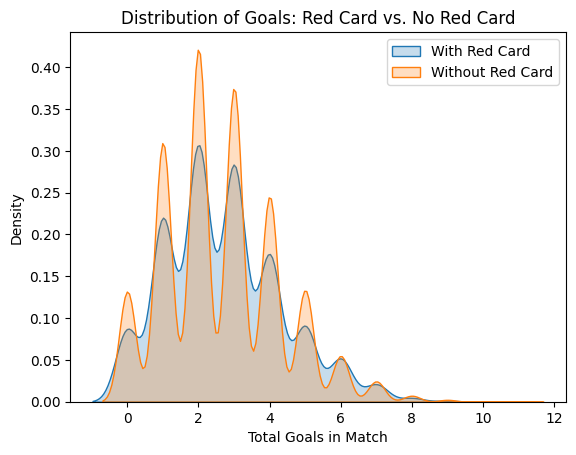

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(goalsPerGameWithRed, label='With Red Card', shade=True)
sns.kdeplot(goalsPerGameWithoutRed, label='Without Red Card', shade=True)
plt.xlabel('Total Goals in Match')
plt.ylabel('Density')
plt.title('Distribution of Goals: Red Card vs. No Red Card')
plt.legend()
plt.show()

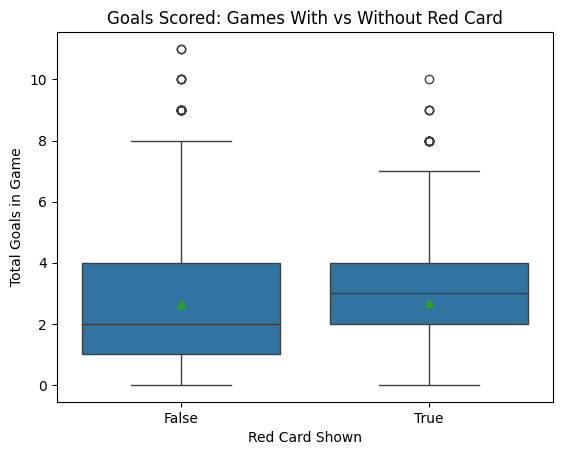

In [ ]:
df_games["total_goals"]
# Plot
sns.boxplot(x='any_red', y='total_goals', data=df_games, showmeans=True)
plt.title('Goals Scored: Games With vs Without Red Card')
plt.ylabel('Total Goals in Game')
plt.xlabel('Red Card Shown')
plt.show()

Median for games without reds are one lower (2) than with reds (3). However the means are quite close, with games with reds scoring 0.05 goals per game more (2.69) than games without (2.64). There are far more games played without a red, so the outliers are more pronounced and affect this stat more than median.

In [ ]:
#Hypothesis test for this analysis
#Use T-test for the means of two independent samples of scores, as games independent from eachother.
import scipy.stats as stats

# Perform the t-test
t_statistic, p_value = stats.ttest_ind(goalsPerGameWithRed, goalsPerGameWithoutRed, equal_var = False) #WELCH TEST FOR UNEQUAL VARIANCES
t_statistic, p_value = stats.ttest_ind(goalsPerGameWithRed, goalsPerGameWithoutRed)
print("T-statistic: "+str(t_statistic))
print("p_value: "+str(p_value/2))



T-statistic: 1.6327223268126638
p_value: 0.05127143353780817


We get a p value of 0.1, which halved is 0.051, which suggests that we have to accept the null hpothesis that on average scoring in games with red is the same as games without reds, as there is not enough evidence to suggest otherwise.

In [ ]:
#Added: Check variance:
print(goalsPerGameWithRed.std())
print(goalsPerGameWithoutRed.std()) #Standard deviations are actually basically the same

1.6446253001014772
1.6393917368697621


#**Analysis 2:**

In the following analysis, we'll calculate exactly how many minutes were
played with 0, 1 and 2+ red cards along with how many goals were scored for each.

We don't introduce any further granularity than 2 red cards as 1.7% had 2 reds while 0.24% of games had 3 or 4 reds, so we'll group these together so we'll get less noisy results for comparison. Also, after a games sees 2 reds, it can be considered a bit of an anomoly, a highly tense quite chaotic game.

This deals with the question of whether MORE red cards lead to MORE goals in general.

In [ ]:
minsNoRed = 0
mins1Red = 0
mins2plusRed = 0

goalsNoRed = 0
goals1Red = 0
goals2plusRed = 0

for i in range(1, 20371):
  df_game = df_evnts.loc[df_evnts['game_id']==i]

  if list(df_game["type"]).count("red_card") >= 2:
    redCnt= list(df_game["type"]).count("red_card")
    minFirstRed = df_game.loc[df_game["type"]=="red_card"]["minute"].iloc[0]
    minsNoRed+= minFirstRed
    minSecondRed = df_game.loc[df_game["type"]=="red_card"]["minute"].iloc[1]
    mins1Red += minSecondRed - minFirstRed
    mins2plusRed += 90 - minSecondRed

    for gt in df_game[df_game["type"]=="goal"]["minute"]:
      if gt < minFirstRed:
        goalsNoRed+=1
        continue
      elif minFirstRed <= gt < minSecondRed:
        goals1Red+=1
        continue
      else:
        goals2plusRed+=1


  if list(df_game["type"]).count("red_card") == 1:
    minFirstRed = df_game.loc[df_game["type"]=="red_card"]["minute"].iloc[0]
    minsNoRed+= minFirstRed
    mins1Red+= 90-minFirstRed
    for goalMin in df_game.loc[df_game["type"]=="goal"]["minute"]:
      if goalMin < minFirstRed:
        goalsNoRed+=1
      else:
        goals1Red+=1
  else:
    minsNoRed+=90
    for goalMin in df_game.loc[df_game["type"]=="goal"]["minute"]:
      goalsNoRed+=1







In [ ]:
print(str(minsNoRed) + " minutes were played without a red card.")
print(str(mins1Red) + " minutes were played with one red card.")
print(str(mins2plusRed) + " minutes were played with two or more red cards.")

print(str(goalsNoRed) + " goals were scored without a red card.")
print(str(goals1Red) + " goals were scored with a red card.")
print(str(goals2plusRed) + " goals were scored with 2 or more red cards.")

goalsPerMinuteNoRed = goalsNoRed/minsNoRed
goalsPerMinute1Red = goals1Red/mins1Red
goalsPerMinute2Red = goals2plusRed/mins2plusRed

goalsPer90NoRed = 90*goalsPerMinuteNoRed
goalsPer90_1Red = 90*goalsPerMinute1Red
goalsPer90_2Red = 90*goalsPerMinute2Red


print(str(goalsPerMinuteNoRed) + " goals per minute without a red card.")
print(str(goalsPerMinute1Red) + " goals per minute with a red card.")
print(str(goalsPerMinute2Red) + " goals per minute with 2 red cards or more.")

print(str(goalsPer90NoRed) + " goals per minute without a red card.")
print(str(goalsPer90_1Red) + " goals per minute with a red card.")
print(str(goalsPer90_2Red) + " goals per minute with 2 red cards or more.")

#So immediately we can see there is an increase in goals after the first red card.
#Huge increase per 90 in goals after 1 red, which causaly answers our question more deeply than before
#Suprisingly a drop off after 2 reds, could be explained by these games being very chaotic.
#So one red certainly means more goals, as does at least one, but more reds doesn't increase likelihood further.
#This increase doesn't increase linearly.

1784122 minutes were played without a red card.
77633 minutes were played with one red card.
7725 minutes were played with two or more red cards.
51774 goals were scored without a red card.
3088 goals were scored with a red card.
265 goals were scored with 2 or more red cards.
0.029019315943640624 goals per minute without a red card.
0.039776898999136966 goals per minute with a red card.
0.0343042071197411 goals per minute with 2 red cards or more.
2.611738434927656 goals per minute without a red card.
3.579920909922327 goals per minute with a red card.
3.087378640776699 goals per minute with 2 red cards or more.


In [ ]:
1784122+77633
1833300

1833300

In [ ]:
#Summarise data
data = {
    "Red Card State": ["No Red Card", "1 Red Card", "2+ Red Cards", "Any Red Card (1+)"],
    "Minutes Played": [1784122, 77633, 7725, 77633 + 7725],
    "Goals Scored": [51774, 3088, 265, 3088 + 265],
}

# Create DataFrame
df_summary = pd.DataFrame(data)

# Calculate Goals per 90 Minutes
df_summary["Goals per 90"] = (df_summary["Goals Scored"] / df_summary["Minutes Played"]) * 90
df_summary["Goals per 90"] = df_summary["Goals per 90"].round(2)

# Display
df_summary

,Red Card State,Minutes Played,Goals Scored,Goals per 90
0,No Red Card,1784122,51774,2.61
1,1 Red Card,77633,3088,3.58
2,2+ Red Cards,7725,265,3.09
3,Any Red Card (1+),85358,3353,3.54


In [ ]:
90 * (51774 +3088+265)/(1784122 + 77633+7725) #san check, all good

2.6539091084151742

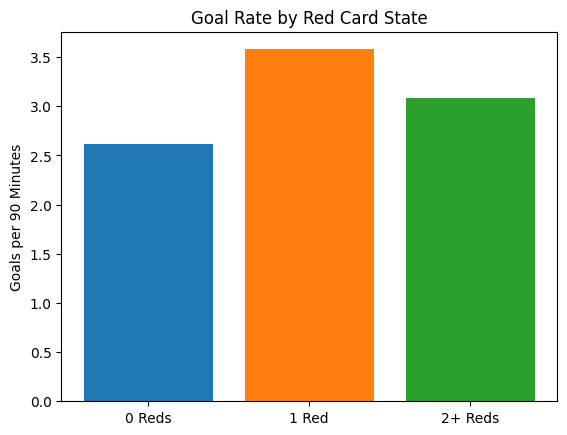

In [ ]:
#Visualise this with bar chart
labels = ['0 Reds', '1 Red', '2+ Reds']
goal_rates = [goalsPer90NoRed, goalsPer90_1Red, goalsPer90_2Red]

plt.bar(labels, goal_rates, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.ylabel('Goals per 90 Minutes')
plt.title('Goal Rate by Red Card State')
plt.show()

Let's do a **hypothesis test** to see whether the presence of a red card in a game does in fact imply a hugher likelihood of goals.

In [ ]:
#Let's combine the stats for 1 red and 2plus reds
goals1plusRed = goals1Red + goals2plusRed
mins1plusRed = mins2plusRed + mins1Red

goalsPerMinute1plusRed = goals1plusRed/mins1plusRed

goalsPer90_1plusRed = 90*goalsPerMinute1plusRed
goalsPer90_1plusRed

#Let's do hypothesis test
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

# Set up test
count = np.array([goals1plusRed, goalsNoRed])
nobs = np.array([mins1plusRed, minsNoRed])

# Run z-test for difference in proportions
z_stat, p_val = proportions_ztest(count, nobs, alternative='larger')  # "larger" = test if red leads to *more* goals

print(f"Z-statistic: {z_stat:.3f}")
print(f"P-value: {p_val:.5f}")

Z-statistic: 17.314
P-value: 0.00000


We found extremely strong statistical evidence that goals are more likely to be scored in minutes where at least one red card is in effect. The p-value was effectively 0, suggesting the observed difference is highly unlikely to be due to chance.

**Analysis 1 and 2 comparison note**

I would say looking at analysis 1 compared to analysis 2, we could argue that games with red cards aren't inherently more open or higher scoring, as more goals are definitively scored in the minutes following the first red but games with reds in general didn't have to many more goals per game.



In [ ]:
#Let's analyse our choice of hypothesis test.
goalsPer90_1plusRed
goalsPer90NoRed
p = (goals1plusRed+goalsNoRed)/(mins1plusRed + minsNoRed)
(goalsPerMinute1plusRed-goalsPerMinuteNoRed)/np.sqrt(p*(1-p)*(1/mins1plusRed + 1/minsNoRed))
#Results the same, therefore
#Confirms this is a regular z-test for comparing two proportions

#Let's run it, assuming proportions stay the same but use less samples for no red
#Let's analyse our choice of hypothesis test.

p = (goals1plusRed+goalsNoRed)/(mins1plusRed + minsNoRed)
(goalsPerMinute1plusRed-goalsPerMinuteNoRed)/np.sqrt(p*(1-p)*(1/mins1plusRed + 1/mins1plusRed))
#Results 12, still signicantly larger.



np.float64(12.532262645456349)

np.int64(1784122)

#**Analysis 3**

The previous analysis suggests that in general more goals are scored in the minutes following a red card than before.The average first red card time is 63 minutes. However, this could be due to many factors. Perhaps in general, more goals are scored in the later stages of games anyways? Instead of taking all minutes played without a red, let's now only take minutes from a similar time frame as those played with at least one red.

In [ ]:
df_evnts[df_evnts["type"]=="red_card"]["minute"].mean() #average over all reds.
df_evnts[df_evnts["type"]=="red_card"]["minute"].std()

#As we've already seen second red doesn't increase goals any further, we'll take only first red minute
firstReds = df_evnts[df_evnts["type"]=="red_card"].drop_duplicates(subset="game_id", keep="first")
print(firstReds["minute"].mean())
print(firstReds["minute"].std())

lstMinsPlayed=[]
for i in firstReds["minute"]:
  for j in range(i, 91):
    lstMinsPlayed.append(j)





63.92056217537427
23.60923311317855


In [ ]:
sns.histplot(lstMinsPlayed, bins=90, kde=False)
plt.title("Distribution of Minutes Played with a Red Card")
plt.xlabel("Minute")
plt.ylabel("Count")
plt.show()

NameError: name 'sns' is not defined

In [ ]:
print("Lower quartile: "+str(np.quantile(lstMinsPlayed, 0.25)))
print("Higher quartile: "+str(np.quantile(lstMinsPlayed, 0.75)))
print("Median: "+str(np.quantile(lstMinsPlayed, 0.5)))
# Plot
sns.boxplot(data=lstMinsPlayed, showmeans=True)
plt.title('Distribution of minutes played with at least one red card')
plt.ylabel('Minute in game')
plt.show()

Lower quartile: 55.0
Higher quartile: 82.0
Median: 71.0


NameError: name 'sns' is not defined

array([[<Axes: title={'center': 'minute'}>]], dtype=object)

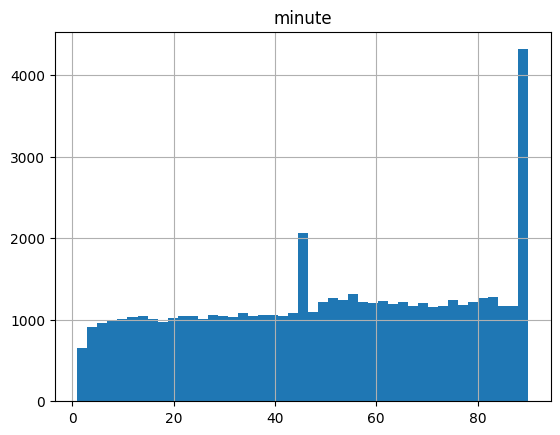

In [ ]:
#In general, when are most goals scored?
df_evnts.loc[df_evnts["type"]=="goal"].hist("minute", bins=45)

In [ ]:
print(len(df_evnts.loc[df_evnts["type"]=="goal"].loc[df_evnts["minute"]==45])) #over 3 times the amount of goals on 44
print(len(df_evnts.loc[df_evnts["type"]=="goal"].loc[df_evnts["minute"]==90])) #6 times the amount of goals on 89

1721
3715


In [ ]:
df_evnts

,game_id,minute,side,type
0,1,69,home,red_card
1,4,90,home,red_card
2,14,85,away,red_card
3,26,90,away,red_card
4,41,89,home,red_card
...,...,...,...,...
57745,20368,85,home,goal
57746,20369,43,home,goal
57747,20369,90,home,goal
57748,20369,6,away,goal


Only cosidering goals scored and minutes played from 55-90 minutes, we consider red carded and non red carded periods.

In [ ]:
timeFrom = np.floor(firstReds["minute"].mean())
timeFrom = 55

minsNoRed = 0
mins1plusRed = 0

goalsNoRed = 0
goals1plusRed = 0

for i in range(1, 20371):
  df_game = df_evnts.loc[df_evnts['game_id']==i]

  if list(df_game["type"]).count("red_card") >= 1:
    redCnt= list(df_game["type"]).count("red_card")
    minFirstRed = df_game.loc[df_game["type"]=="red_card"]["minute"].iloc[0]
    minsNoRed+= max(0, minFirstRed - timeFrom) #Only considering goals/minutes from certain point here, and has to be>0
    mins1plusRed += 90 - max(minFirstRed, timeFrom) #Only considering goals and minutes from after cut of for withReds too

    for gt in df_game[df_game["type"]=="goal"]["minute"]:
      if timeFrom <= gt < minFirstRed:
        goalsNoRed+=1
        continue
      elif max(minFirstRed, timeFrom) <= gt: #Considers only goals after cut off
        goals1plusRed+=1
        continue
  else:
    minsNoRed+=90 - timeFrom #Only add time after your cut off
    for gt in df_game.loc[df_game["type"]=="goal"]["minute"]:
      if timeFrom < gt: #only consider goals after cut off
        goalsNoRed+=1

#Output our results
print("Taking the cut off minute as: "+str(timeFrom))
print(str(minsNoRed) + " minutes were played without a red card in this time frame.")
print(str(mins1plusRed) + " minutes were played with at least one red card.")

print(str(goalsNoRed) + " goals were scored without a red card.")
print(str(goals1plusRed) + " goals were scored with at least one red card.")

goalsPerMinuteNoRed = goalsNoRed/minsNoRed
goalsPerMinute1plusRed = goals1plusRed/mins1plusRed

goalsPer90NoRed = 90*goalsPerMinuteNoRed
goalsPer90_1plusRed = 90*goalsPerMinute1plusRed

print(str(goalsPerMinuteNoRed) + " goals per minute without a red card.")
print(str(goalsPerMinute1plusRed) + " goals per minute with a red card.")

print(str(goalsPer90NoRed) + " goals per 90 without a red card.")
print(str(goalsPer90_1plusRed) + " goals per 90 with at least one red card.")
print(str(100*(goalsPer90_1plusRed-goalsPer90NoRed)/goalsPer90NoRed) + " percentage increase")

Taking the cut off minute as: 55
649123 minutes were played without a red card in this time frame.
63827 minutes were played with at least one red card.
21741 goals were scored without a red card.
2653 goals were scored with at least one red card.
0.033492881934548614 goals per minute without a red card.
0.04156548169270058 goals per minute with a red card.
3.0143593741093753 goals per 90 without a red card.
3.7408933523430523 goals per 90 with at least one red card.
24.10243398560728 percentage increase


In [ ]:
#Let update it to have similar sample sizes.
len(df_games.loc[df_games["any_red"]==True]) #3273 games with a red
len(df_games.loc[df_games["any_red"]==False]) #17097 games with a red

#Let's take 3000 games from each
df_redGames = df_games.loc[df_games["any_red"]==True]
df_noRedGames = df_games.loc[df_games["any_red"]==False]

df_redGamesSample = df_redGames.sample(n=3000, random_state=23)
df_noRedGamesSample = df_noRedGames.sample(n=500, random_state=23)

df_sample = pd.concat([df_redGamesSample, df_noRedGamesSample])

#for i in df_sample["game_id"]:
  #print(i)

In [ ]:
timeFrom = np.floor(firstReds["minute"].mean())
timeFrom = 55

minsNoRed = 0
mins1plusRed = 0

goalsNoRed = 0
goals1plusRed = 0

for i in df_sample["game_id"]:
  df_game = df_evnts.loc[df_evnts['game_id']==i]

  if list(df_game["type"]).count("red_card") >= 1:
    redCnt= list(df_game["type"]).count("red_card")
    minFirstRed = df_game.loc[df_game["type"]=="red_card"]["minute"].iloc[0]
    minsNoRed+= max(0, minFirstRed - timeFrom) #Only considering goals/minutes from certain point here, and has to be>0
    mins1plusRed += 90 - max(minFirstRed, timeFrom) #Only considering goals and minutes from after cut of for withReds too

    for gt in df_game[df_game["type"]=="goal"]["minute"]:
      if timeFrom <= gt < minFirstRed:
        goalsNoRed+=1
        continue
      elif max(minFirstRed, timeFrom) <= gt: #Considers only goals after cut off
        goals1plusRed+=1
        continue
  else:
    minsNoRed+=90 - timeFrom #Only add time after your cut off
    for gt in df_game.loc[df_game["type"]=="goal"]["minute"]:
      if timeFrom < gt: #only consider goals after cut off
        goalsNoRed+=1

#Output our results
print("Taking the cut off minute as: "+str(timeFrom))
print(str(minsNoRed) + " minutes were played without a red card in this time frame.")
print(str(mins1plusRed) + " minutes were played with at least one red card.")

print(str(goalsNoRed) + " goals were scored without a red card.")
print(str(goals1plusRed) + " goals were scored with at least one red card.")

goalsPerMinuteNoRed = goalsNoRed/minsNoRed
goalsPerMinute1plusRed = goals1plusRed/mins1plusRed

goalsPer90NoRed = 90*goalsPerMinuteNoRed
goalsPer90_1plusRed = 90*goalsPerMinute1plusRed

print(str(goalsPerMinuteNoRed) + " goals per minute without a red card.")
print(str(goalsPerMinute1plusRed) + " goals per minute with a red card.")

print(str(goalsPer90NoRed) + " goals per 90 without a red card.")
print(str(goalsPer90_1plusRed) + " goals per 90 with at least one red card.")
print(str(100*(goalsPer90_1plusRed-goalsPer90NoRed)/goalsPer90NoRed) + " percentage increase")

Taking the cut off minute as: 55
63904 minutes were played without a red card in this time frame.
58596 minutes were played with at least one red card.
1885 goals were scored without a red card.
2426 goals were scored with at least one red card.
0.029497371056584877 goals per minute without a red card.
0.04140214349102328 goals per minute with a red card.
2.654763395092639 goals per 90 without a red card.
3.726192914192095 goals per 90 with at least one red card.
40.35875743503191 percentage increase


Let's visualise the results for 55-90 minutes for the two groups (red and no red)

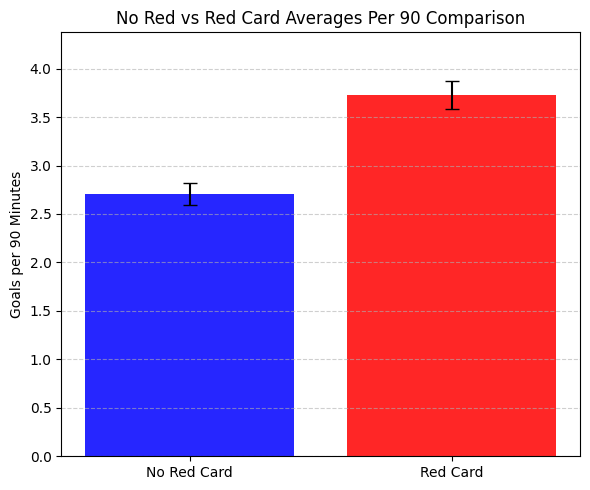

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.proportion import proportion_confint

# Inputs
goals = np.array([goalsNoRed, goals1plusRed])
minutes = np.array([minsNoRed, mins1plusRed])
goals_per_90 = np.array([goalsPer90NoRed, goalsPer90_1plusRed])

# Confidence intervals (Wilson method)
ci_low, ci_upp = proportion_confint(goals, minutes, method='wilson')
ci_low_90 = ci_low * 90
ci_upp_90 = ci_upp * 90
error = [goals_per_90 - ci_low_90, ci_upp_90 - goals_per_90]

# Labels and colors (No Red on left)
labels = ['No Red Card', 'Red Card']
colors = ['blue', 'red']

# Plot
plt.figure(figsize=(6, 5))
plt.bar(labels, goals_per_90, color=colors, yerr=error, capsize=5, alpha=0.85)
plt.ylabel("Goals per 90 Minutes")
plt.title("No Red vs Red Card Averages Per 90 Comparison")
plt.ylim(0, max(ci_upp_90) + 0.5)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In general, as there are way more games without a red than with, and because we count the goals in the 90th minutes but not the extra minutes, the goal rates will be lower in reality than our non-red calculations. More games means more minutes missed, more times including this 90th minute, means a bigger scoring rate.

Given this fact, the fact that we see an increase in the rate of increase from non-red to red scoring rates is important. It could suggest that red cards have a bigger impact closer to the end of the game becuase of fatigue.

Could try mitigate for this by adding a reasonable average injury time constant for each game.

Also affects red cards because if we see a red in the 91st minute, it gets put down as 90 minutes, and if there was a goal in the 90th minute, instead of being calculated as a non-red card goal it's actually recorded as a red goal.

Let's run a hypothesis test now to see whether this is conclusive.

In [ ]:
#Do our numbers of observations meet the requirements for z testing:
#necessary for np and n(1-p)


#63904 minutes were played without a red card in this time frame.
#58596 minutes were played with at least one red card.
#1885 goals were scored without a red card.
#2426 goals were scored with at least one red card.

(63904+58596)*(1885/63904)
(63904+58596)*(1 - 1885/63904) #Completely fine

118886.57204556835

In [ ]:
#Let's do hypothesis test
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

# Set up test
#count = np.array([goalsNoRed, goals1plusRed])
#nobs = np.array([minsNoRed, mins1plusRed])

count = np.array([goals1plusRed, goalsNoRed])
nobs = np.array([mins1plusRed, minsNoRed])

# Run z-test for difference in proportions
z_stat, p_val = proportions_ztest(count, nobs, alternative='larger')  # "larger" = test if red leads to *more* goals

print(f"Z-statistic: {z_stat:.3f}")
print(f"P-value: {p_val:.4f}")

Z-statistic: 11.296
P-value: 0.0000


When we equate sample sizes, test stat actually got bigger.

In [ ]:
#lowering sample size and goals scored while keeping proportion same for non red, see if same z test
# Run z-test for difference in proportions
count2 = np.array([goals1plusRed, goalsNoRed//10])
nobs2 = np.array([mins1plusRed, minsNoRed//10])
z_stat2, p_val2 = proportions_ztest(count, nobs, alternative='larger')  # "larger" = test if red leads to *more* goals

print(f"Z-statistic: {z_stat2:.3f}")
print(f"P-value: {p_val2:.4f}")

#No difference

Z-statistic: 10.705
P-value: 0.0000


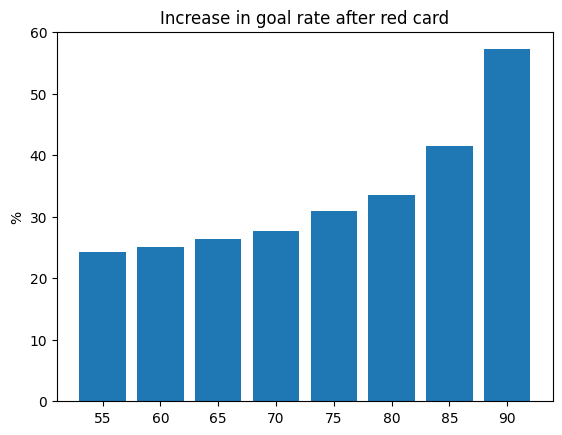

In [ ]:
#We can also track the change in % increase from red to non red minutes as we increased the cut off time
percInc = [24.252491694352177, 25.12867459633308, 26.444322983224435, 27.658540304794936, 30.913898399739455, 33.44531406054224, 41.40866164675501, 57.19428129080581]
#Visualise this with bar chart
labels = ['55', '60', '65', "70", "75", "80", "85", "90"]

plt.bar(labels, percInc)
plt.ylabel('%')
plt.title('Increase in goal rate after red card')
plt.show()

In [ ]:
##EXTRA WORK:
#Bayes Method
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt

# Your observed data
goals_no_red = goalsNoRed
minutes_no_red = minsNoRed

goals_red = goals1plusRed
minutes_red = mins1plusRed

# Posterior distributions (Beta priors: 1,1)
a1, b1 = 1 + goals_no_red, 1 + minutes_no_red - goals_no_red
a2, b2 = 1 + goals_red,     1 + minutes_red - goals_red

# Draw samples
samples1 = beta.rvs(a1, b1, size=10000)
samples2 = beta.rvs(a2, b2, size=10000)

# Compare
prob_red_higher = np.mean(samples2 > samples1)
print(f"Probability that red-card minutes have higher goal rate: {prob_red_higher:.4f}")


Probability that red-card minutes have higher goal rate: 1.0000


#**Analysis 4: Difference between leagues**



Next we want to see if the effect on a league to league basis. We'll repeat our analysis from part 3 taking only goals and minutes from roughly the 60th minute because we found conclusively there were way more goals after this anyways, so it is unfair to compare red carded minutes (which are predominantly in second half) with entire non red carded games (which are over entire 90 minute spectrum).

Let's have a look at Englands leagues, see if we notice a pattern. We can reapply techniques to other countries then to see.

In [ ]:
englishLeagues = ['Premier League, England', 'Championship, England', 'League One, England',
       'League Two, England']

allLeagues = df_games["competition"].unique()
allLeagues.sort()
allLeagues

array(['1. Bundesliga, Germany', '2. Bundesliga, Germany',
       'Championship, England', 'League One, England',
       'League Two, England', 'Ligue 1, France', 'Ligue 2, France',
       'Premier League, England', 'Primera, Spain', 'Serie A, Italy'],
      dtype=object)

In [ ]:
timeFrom = 55

#Add them into a summary table at end.
goalPer90NoRedList = []
goalsPer90WithRedList = []
goalsPer90List = []

for league in allLeagues:
  df_leagueGames = df_games.loc[df_games["competition"]==league]
  gameIds = df_games.loc[df_games["competition"]==league]["game_id"]
  minsNoRed = 0
  mins1plusRed = 0

  goalsNoRed = 0
  goals1plusRed = 0

  for i in gameIds:
    df_game = df_evnts.loc[df_evnts['game_id']==i]
    #print(df_game)
    if list(df_game["type"]).count("red_card") >= 1:
      redCnt= list(df_game["type"]).count("red_card")
      minFirstRed = df_game.loc[df_game["type"]=="red_card"]["minute"].iloc[0]
      minsNoRed+= max(0, minFirstRed - timeFrom) #Only considering goals/minutes from certain point here, and has to be>0
      mins1plusRed += 90 - max(minFirstRed, timeFrom) #Only considering goals and minutes from after cut of for withReds too

      for gt in df_game[df_game["type"]=="goal"]["minute"]:
        if timeFrom <= gt < minFirstRed:
          goalsNoRed+=1
          continue
        elif max(minFirstRed, timeFrom) <= gt: #So this considers goals scored with reds even before cut off time?? Maybe should only consider after cut of time too.
          goals1plusRed+=1
          continue
    else:
      minsNoRed+=90 - timeFrom #Only add time after your cut off
      for gt in df_game.loc[df_game["type"]=="goal"]["minute"]:
        if timeFrom <= gt: #only consider goals after cut off
          goalsNoRed+=1
  #Calculated taking nonRed AND with minutes/goals from cut off of 63
  print("For "+str(league)+":::::::::::::::::::::::::::::::::::::::::")
  print(str(minsNoRed) + " minutes were played without a red card.")
  print(str(mins1plusRed) + " minutes were played with at least one red card.")

  print(str(goalsNoRed) + " goals were scored without a red card.")
  print(str(goals1plusRed) + " goals were scored with at least one red card.")

  goalsPerMinuteNoRed = goalsNoRed/minsNoRed
  goalsPerMinute1plusRed = goals1plusRed/mins1plusRed

  goalsPer90NoRed = 90*goalsPerMinuteNoRed
  goalsPer90_1plusRed = 90*goalsPerMinute1plusRed

  print(str(goalsPer90NoRed) + " goals per 90 without a red card.")
  print(str(goalsPer90_1plusRed) + " goals per 90 with at least one red card.")
  goalPer90NoRedList.append(goalsPer90NoRed)
  goalsPer90WithRedList.append(goalsPer90_1plusRed)
  goalsPer90List.append(90*(goalsNoRed+goals1plusRed)/(minsNoRed+mins1plusRed))


For 1. Bundesliga, Germany:::::::::::::::::::::::::::::::::::::::::
49765 minutes were played without a red card.
3785 minutes were played with at least one red card.
2007 goals were scored without a red card.
189 goals were scored with at least one red card.
3.6296593991761275 goals per 90 without a red card.
4.494055482166447 goals per 90 with at least one red card.
For 2. Bundesliga, Germany:::::::::::::::::::::::::::::::::::::::::
48454 minutes were played without a red card.
5096 minutes were played with at least one red card.
1873 goals were scored without a red card.
238 goals were scored with at least one red card.
3.4789697444999383 goals per 90 without a red card.
4.2032967032967035 goals per 90 with at least one red card.
For Championship, England:::::::::::::::::::::::::::::::::::::::::
90369 minutes were played without a red card.
6196 minutes were played with at least one red card.
2990 goals were scored without a red card.
260 goals were scored with at least one red card

In [ ]:
#Santitary CHECKS

52921+4079 == 30 * len(df_games.loc[df_games["competition"]== "Premier League, England"]) #SANITARY CHECK: Mins with/without red add up t total mins
totalGoals=1907+174 #Total goals scored

goalCnt = 0
for gameId in df_games.loc[df_games["competition"]== "Premier League, England"]["game_id"]:
  goalCnt+= len(df_evnts.loc[df_evnts["game_id"]==gameId].loc[df_evnts["type"]=="goal"].loc[df_evnts["minute"]>=60])

print(goalCnt == totalGoals)

True


In [ ]:
cntsRedGamesByLeague = df_games.loc[df_games["any_red"]==True].groupby("competition").count()["any_red"]

In [ ]:
df_games.groupby("competition").count()["any_red"]

,any_red
competition,
"1. Bundesliga, Germany",1530
"2. Bundesliga, Germany",1530
"Championship, England",2759
"League One, England",2608
"League Two, England",2648
"Ligue 1, France",1799
"Ligue 2, France",1797
"Premier League, England",1900
"Primera, Spain",1900


In [ ]:
#Summarise data
data = {
    "GamesWithRedCard": cntsRedGamesByLeague,
    "TotalGames": df_games.groupby("competition").count()["any_red"],
    "% of overall games": 100 * df_games.groupby("competition").count()["any_red"]/20370,
    "GoalsPer90WithoutRed": goalPer90NoRedList,
    "GoalsPer90WithRed": goalsPer90WithRedList,
    "GoalsPer90": goalsPer90List
    }

# Create DataFrame
df_summary = pd.DataFrame(data)
df_summary["percIncrease"] = 100*(df_summary["GoalsPer90WithRed"] - df_summary["GoalsPer90WithoutRed"])/df_summary["GoalsPer90WithoutRed"]

# Display
df_summary

,GamesWithRedCard,TotalGames,% of overall games,GoalsPer90WithoutRed,GoalsPer90WithRed,GoalsPer90,percIncrease
competition,,,,,,,
"1. Bundesliga, Germany",184,1530,7.511046,3.629659,4.494055,3.690756,23.814799
"2. Bundesliga, Germany",264,1530,7.511046,3.478970,4.203297,3.547899,20.820157
"Championship, England",317,2759,13.544428,2.977791,3.776630,3.029048,26.826564
"League One, England",341,2608,12.803142,2.990766,3.779736,3.049628,26.380190
"League Two, England",378,2648,12.999509,2.821011,3.261963,2.857898,15.630996
"Ligue 1, France",400,1799,8.831615,3.110656,3.779257,3.203208,21.493860
"Ligue 2, France",409,1797,8.821797,2.739837,3.035114,2.780348,10.777175
"Premier League, England",203,1900,9.327442,3.162021,3.773292,3.203459,19.331656
"Primera, Spain",412,1900,9.327442,2.938445,4.031528,3.043759,37.199350


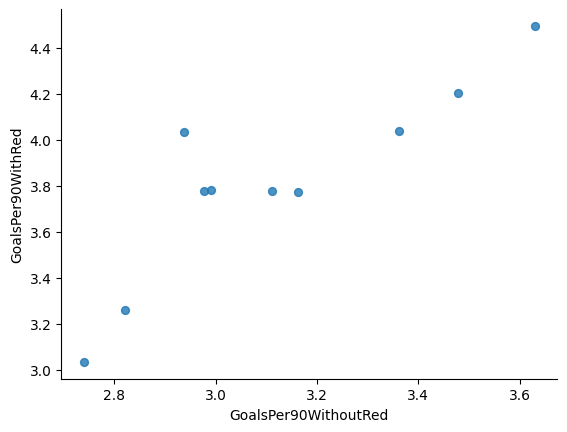

In [ ]:
# @title GoalsPer90WithoutRed vs GoalsPer90WithRed

from matplotlib import pyplot as plt
df_summary.plot(kind='scatter', x='GoalsPer90WithoutRed', y='GoalsPer90WithRed', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

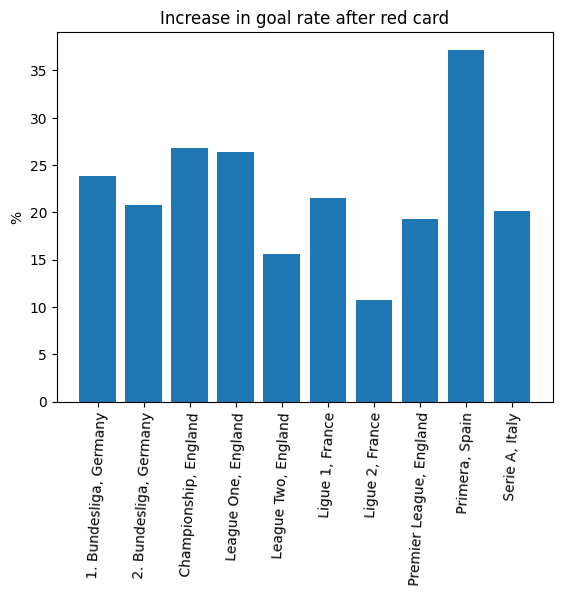

In [ ]:
#We can also track the change in % increase from red to non red minutes as we increased the cut off time
#Visualise this with bar chart
labels = allLeagues

plt.bar(labels, df_summary["percIncrease"])
plt.xticks(rotation=87)
plt.ylabel('%')
plt.title('Increase in goal rate after red card')
plt.show()

Next we'll run a linear regression algorithm so see how well we can predict goals scored after a red with goals scored before.

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


                            OLS Regression Results                            
Dep. Variable:      GoalsPer90WithRed   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     26.59
Date:                Wed, 09 Jul 2025   Prob (F-statistic):           0.000867
Time:                        13:31:20   Log-Likelihood:                 2.2051
No. Observations:                  10   AIC:                           -0.4101
Df Residuals:                       8   BIC:                            0.1950
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2084 

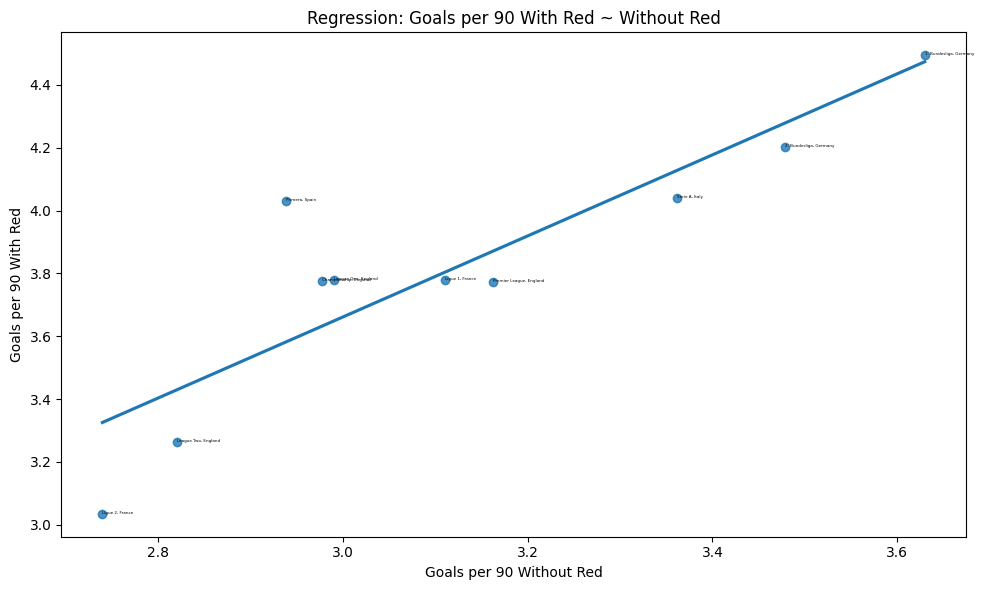

In [ ]:
import statsmodels.api as sm
df_summary["Competition"] = allLeagues

# Independent and dependent variables
X = df_summary["GoalsPer90WithoutRed"]
y = df_summary["GoalsPer90WithRed"]

# Add constant term for intercept
X_const = sm.add_constant(X)

# Fit linear regression model
model = sm.OLS(y, X_const).fit()

# View regression summary
print(model.summary())

# Optional: make predictions
df_summary["Predicted_WithRed"] = model.predict(X_const)
df_summary["Residual"] = df_summary["GoalsPer90WithRed"] - df_summary["Predicted_WithRed"]

# Plot regression line and points
plt.figure(figsize=(10, 6))
sns.regplot(x="GoalsPer90WithoutRed", y="GoalsPer90WithRed", data=df_summary, ci=None)
for i in df_summary.index:
    plt.text(df_summary.loc[i, "GoalsPer90WithoutRed"],
             df_summary.loc[i, "GoalsPer90WithRed"],
             df_summary.loc[i, "Competition"], fontsize=3)

plt.title("Regression: Goals per 90 With Red ~ Without Red")
plt.xlabel("Goals per 90 Without Red")
plt.ylabel("Goals per 90 With Red")
plt.tight_layout()
plt.show()

# **Analysis 5: Survival Analysis**

In our fifth analysis we're going to try to conduct a survival analysis. Usually used in medicine or biological studies, it compares how quickly an event happens after a specific time. In our case, we will compare how quickly goals are scored after red cards to how quickly goals are scored from similar points in time in games without red cards. We will enforce this similarity in times by sampling our start time from a distribution derived from the distribution of red card times.

In [ ]:
import random

#Make the data set of games with reds
df_gamesWithReds = df_games.loc[df_games["any_red"]==True]
gameIds = df_games.loc[df_games["any_red"]==True]["game_id"]

firstRedTimes = list(
    df_evnts.loc[df_evnts["type"]=="red_card"].drop_duplicates("game_id")["minute"])

df_gamesWithReds = pd.DataFrame({"game_id": list(gameIds),
                    "firstRedTime": firstRedTimes})
df_gamesWithReds.loc[:, "firstGoalAfterTime"]=91

random.seed(20)
#Make the dataset of games without reds
df_gamesNoReds = df_games.loc[df_games["any_red"]==False]
gameIds = df_games.loc[df_games["any_red"]==False].sample(len(df_gamesWithReds))["game_id"]
df_gamesNoReds = pd.DataFrame({"game_id": list(gameIds),
                               "firstRedTime": firstRedTimes})
df_gamesNoReds.loc[:, "firstGoalAfterTime"]=91

#Pull goals into one dataset too
df_goals = df_evnts[df_evnts["type"]=="goal"]



In [ ]:
#Create our data for GAMES WITH REDS
#Add first goal time after red to df_gamesWithReds
for i in range(len(df_gamesWithReds)):
  gm = df_gamesWithReds.iloc[i]
  #print(gm)
  firstGoalAfterTime = df_goals.loc[df_goals["game_id"]==gm["game_id"]].loc[df_goals["minute"]>gm["firstRedTime"]]["minute"].min();
  if firstGoalAfterTime>0:
    df_gamesWithReds.loc[i, "firstGoalAfterTime"] = firstGoalAfterTime;


In [ ]:
df_gamesWithReds

,game_id,firstRedTime,firstGoalAfterTime
0,1,69,90
1,4,90,91
2,14,85,90
3,26,90,91
4,41,89,91
...,...,...,...
3268,20353,90,91
3269,20355,81,91
3270,20359,70,90
3271,20365,67,74


In [ ]:
df_reds = df_gamesWithReds.copy()

# Create 'event' column: 1 if goal occurred, 0 if not
df_reds["event"] = df_reds["firstGoalAfterTime"] != 91

# Calculate duration: if goal happened, it's goal_time - red_time; otherwise, time until game end (e.g., 90 - red_time)
df_reds["duration"] = df_reds.apply(
    lambda row: row["firstGoalAfterTime"] - row["firstRedTime"] if row["event"] else 91 - row["firstRedTime"],
    axis=1)

# Add group label
df_reds["group"] = "red"


In [ ]:
df_reds

,game_id,firstRedTime,firstGoalAfterTime,event,duration,group
0,1,69,90,True,21,red
1,4,90,91,False,1,red
2,14,85,90,True,5,red
3,26,90,91,False,1,red
4,41,89,91,False,2,red
...,...,...,...,...,...,...
3268,20353,90,91,False,1,red
3269,20355,81,91,False,10,red
3270,20359,70,90,True,20,red
3271,20365,67,74,True,7,red


In [ ]:
#Add first goal time after red to df_gamesNoReds
for i in range(len(df_gamesNoReds)):
  gm = df_gamesNoReds.iloc[i]
  #print(gm)
  firstGoalAfterTime = df_goals.loc[df_goals["game_id"]==gm["game_id"]].loc[df_goals["minute"]>gm["firstRedTime"]]["minute"].min();
  if firstGoalAfterTime>0:
    df_gamesNoReds.loc[i, "firstGoalAfterTime"] = firstGoalAfterTime;



In [ ]:
df_noReds = df_gamesNoReds.copy()

df_noReds["event"] = df_noReds["firstGoalAfterTime"] != 91

df_noReds["duration"] = df_noReds.apply(
    lambda row: row["firstGoalAfterTime"] - row["firstRedTime"] if row["event"] else 91 - row["firstRedTime"],
    axis=1
)

df_noReds["group"] = "no_red"


In [ ]:
df_noReds

,game_id,firstRedTime,firstGoalAfterTime,event,duration,group
0,17602,69,91,False,22,no_red
1,7659,90,91,False,1,no_red
2,3451,85,91,False,6,no_red
3,6916,90,91,False,1,no_red
4,12838,89,90,True,1,no_red
...,...,...,...,...,...,...
3268,18350,90,91,False,1,no_red
3269,2874,81,91,False,10,no_red
3270,16169,70,91,False,21,no_red
3271,6905,67,91,False,24,no_red


In [ ]:
#Combine these two datas into one
df_survival = pd.concat([df_reds, df_noReds], ignore_index=True)[["duration", "event", "group"]]



In [ ]:
df_survival

,duration,event,group
0,21,True,red
1,1,False,red
2,5,True,red
3,1,False,red
4,2,False,red
...,...,...,...
6541,1,False,no_red
6542,10,False,no_red
6543,21,False,no_red
6544,24,False,no_red


In [ ]:
pip install lifelines


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 7.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=173a0dc6049fbd316ee2a0e415558836f0b1f9dfdb5fb0da95077d8799612a9b
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


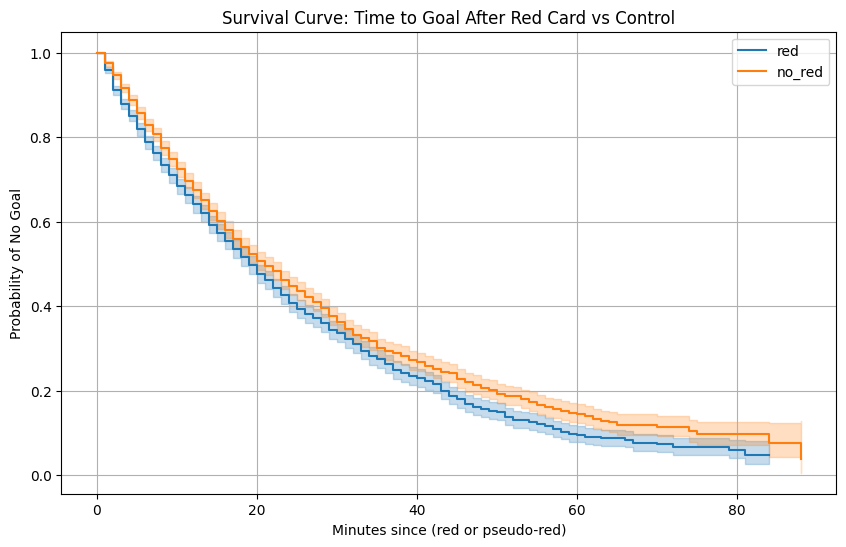

In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

for group in ['red', 'no_red']:
    mask = df_survival['group'] == group
    kmf.fit(durations=df_survival[mask]['duration'],
            event_observed=df_survival[mask]['event'],
            label=group)
    kmf.plot_survival_function()

plt.title("Survival Curve: Time to Goal After Red Card vs Control")
plt.xlabel("Minutes since (red or pseudo-red)")
plt.ylabel("Probability of No Goal")
plt.grid(True)
plt.show()


In [ ]:
from lifelines.statistics import logrank_test

results = logrank_test(
    df_reds["duration"], df_noReds["duration"],
    event_observed_A=df_noReds["event"],
    event_observed_B=df_noReds["event"]
)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.95 0.03      5.26

So games do expect to see goals sooner when there's been a red than not. This coupled with our assertion earlier that more goals are scored in general in minutes where there are at least one red cards present is a robust conclusion in the affirmative of the original question: "Do red cards seem to lead to more goals?"

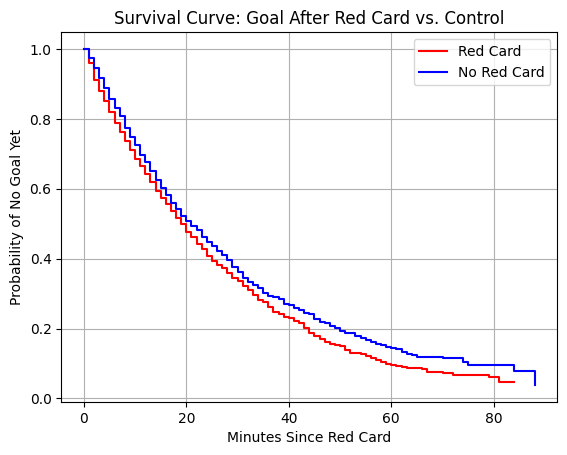

In [ ]:
kmf_red = KaplanMeierFitter()
kmf_nored = KaplanMeierFitter()

# Fit to the two datasets
mask = df_survival['group'] == "red"
kmf_red.fit(durations=df_survival[mask]['duration'],
            event_observed=df_survival[mask]['event'],
            label="Red Card")

mask = df_survival['group'] == "no_red"
kmf_nored.fit(durations=df_survival[mask]['duration'],
            event_observed=df_survival[mask]['event'],
            label="No Red Card")

# Plot with custom colors
ax = kmf_red.plot(ci_show=False, color='red')
kmf_nored.plot(ax=ax, ci_show=False, color='blue')

plt.xlabel("Minutes Since Red Card")
plt.ylabel("Probability of No Goal Yet")
plt.title("Survival Curve: Goal After Red Card vs. Control")
plt.grid(True)
plt.show()